In [2]:
# General libraries
import numpy as np
import pandas as pd
import re
import joblib
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, LabelEncoder
# Outlier Detection
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
# Clustering
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
# SOM
from minisom import MiniSom
# Evaluation Metrics
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
# Statistics
from scipy.stats import skew

<div style="text-align: center;">
  <h1>Load Data</h1>
</div>


In [3]:
recipes_df = pd.read_csv('RecipeData.csv')
allergen_df = pd.read_csv('AllergenData.csv')

<div style="text-align: center;">
  <h1>Preview Data</h1>
</div>

In [12]:
display(recipes_df.head())
display(allergen_df.head())

,RecipeId,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,Images,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38,Low-Fat Berry Blue Frozen Dessert,1533,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39,Biryani,1567,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,"c(""https://img.sndimg.com/food/image/upload/w_...",...,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40,Best Lemonade,1566,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41,Carina's Tofu-Vegetable Kebabs,1586,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,"c(""https://img.sndimg.com/food/image/upload/w_...",...,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc..."
4,42,Cabbage Soup,1538,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,"""https://img.sndimg.com/food/image/upload/w_55...",...,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,NaN,"c(""Mix everything together and bring to a boil..."


,Class,Type,Group,Food,Allergy
0,Plant origin,Nut and seed,Oil seed,Almond,Nut Allergy
1,Plant origin,Fruit,Pome fruit,Apple,Oral Allergy Syndrome
2,Plant origin,Fruit,Stone fruit,Apricot,Stone Fruit Allergy
3,Plant origin,Vegetable,Composite vegetable,Artichoke,Insulin Allergy
4,Plant origin,Vegetable,Liliaceous vegetable,Asparagus,Allium Allergy


<div style="text-align: center;">
  <h1>Duplication Checking</h1>
</div>

In [13]:
duplicate_recipes = recipes_df[recipes_df.duplicated()]
print(f"🧾 Recipes - Duplicate rows: {len(duplicate_recipes)}")
duplicate_allergens = allergen_df[allergen_df.duplicated()]
print(f"🍽️ Allergens - Duplicate rows: {len(duplicate_allergens)}")

🧾 Recipes - Duplicate rows: 0
🍽️ Allergens - Duplicate rows: 0


<div style="text-align: center;">
  <h1>Inspect Structure & Types</h1>
</div>

In [14]:
# Check column names, types, and null counts
print("📄 recipes_df — Column Info\n" + "-"*40)
recipes_df.info()
print("\n")

print("📄 allergen_df — Column Info\n" + "-"*40)
allergen_df.info()

📄 recipes_df — Column Info
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    522517 non-null  int64  
 1   Name                        522517 non-null  object 
 2   AuthorId                    522517 non-null  int64  
 3   AuthorName                  522517 non-null  object 
 4   CookTime                    439972 non-null  object 
 5   PrepTime                    522517 non-null  object 
 6   TotalTime                   522517 non-null  object 
 7   DatePublished               522517 non-null  object 
 8   Description                 522512 non-null  object 
 9   Images                      522516 non-null  object 
 10  RecipeCategory              521766 non-null  object 
 11  Keywords                    505280 non-null  object 
 12  Reci

<div style="text-align: center;">
  <h1>Summary Stats</h1>
</div>

In [15]:
# Summary of numeric data
print("📊 Summary Statistics for Recipes Dataset")
display(recipes_df.describe())
print("📊 Summary Statistics for Allergen Dataset")
display(allergen_df.describe())


📊 Summary Statistics for Recipes Dataset


,RecipeId,AuthorId,AggregatedRating,ReviewCount,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings
count,522517.000000,5.225170e+05,269294.000000,275028.000000,522517.000000,522517.000000,522517.000000,522517.000000,5.225170e+05,522517.000000,522517.000000,522517.000000,522517.000000,339606.000000
mean,271821.436970,4.572585e+07,4.632014,5.227784,484.438580,24.614922,9.559457,86.487003,7.672639e+02,49.089092,3.843242,21.878254,17.469510,8.606191
std,155495.878422,2.929714e+08,0.641934,20.381347,1397.116649,111.485798,46.622621,301.987009,4.203621e+03,180.822062,8.603163,142.620191,40.128837,114.319809
min,38.000000,2.700000e+01,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000
25%,137206.000000,6.947400e+04,4.500000,1.000000,174.200000,5.600000,1.500000,3.800000,1.233000e+02,12.800000,0.800000,2.500000,3.500000,4.000000
50%,271758.000000,2.389370e+05,5.000000,2.000000,317.100000,13.800000,4.700000,42.600000,3.533000e+02,28.200000,2.200000,6.400000,9.100000,6.000000
75%,406145.000000,5.658280e+05,5.000000,4.000000,529.100000,27.400000,10.800000,107.900000,7.922000e+02,51.100000,4.600000,17.900000,25.000000,8.000000
max,541383.000000,2.002886e+09,5.000000,3063.000000,612854.600000,64368.100000,26740.600000,130456.400000,1.246921e+06,108294.600000,3012.000000,90682.300000,18396.200000,32767.000000


📊 Summary Statistics for Allergen Dataset


,Class,Type,Group,Food,Allergy
count,184,184,184,184,162
unique,3,14,33,183,39
top,Plant origin,Vegetable,Cruciferous vegetable,Peas,Legume Allergy
freq,146,64,15,2,14


<div style="text-align: center;">
  <h1>Unique Values</h1>
</div>

In [16]:
# Check unique allergy types
print(allergen_df['Allergy'].unique())

['Nut Allergy' 'Oral Allergy Syndrome' 'Stone Fruit Allergy'
 'Insulin Allergy' 'Allium Allergy' 'Histamine Allergy' 'Banana Allergy'
 'Gluten Allergy' 'Legume Allergy' 'Salicylate Allergy' 'Broccoli allergy'
 'Cruciferous Allergy' 'Ragweed Allergy'
 'Milk allergy / Lactose intolerance' 'Mushroom Allergy' nan
 'Hypersensitivity' 'Alpha-gal Syndrome' 'Poultry Allergy'
 'Ochratoxin Allergy' 'Corn Allergy' 'Seed Allergy' 'Shellfish Allergy'
 'Fish Allergy' 'Nightshade Allergy' 'Sugar Allergy / Intolerance'
 'LTP Allergy' 'Citrus Allergy' 'Honey Allergy' 'Beer Allergy'
 'Potato Allergy' 'Lactose Intolerance' 'Aquagenic Urticaria'
 'Peanut Allergy' 'Mint Allergy' 'Rice Allergy' 'Pepper Allergy'
 'Soy Allergy' 'Tannin Allergy' 'Thyroid']


<div style="text-align: center;">
  <h1>Check Missing Values</h1>
</div>

In [17]:
print("🧾 Missing Values in recipes_df")
print("=" * 40)
print(recipes_df.isnull().sum().sort_values(ascending=False))
print("\n")
print("🧾 Missing Values in allergen_df")
print("=" * 40)
print(allergen_df.isnull().sum().sort_values(ascending=False))

🧾 Missing Values in recipes_df
RecipeYield                   348071
AggregatedRating              253223
ReviewCount                   247489
RecipeServings                182911
CookTime                       82545
Keywords                       17237
RecipeCategory                   751
Description                        5
RecipeIngredientQuantities         3
Images                             1
SaturatedFatContent                0
FiberContent                       0
SugarContent                       0
CarbohydrateContent                0
SodiumContent                      0
ProteinContent                     0
CholesterolContent                 0
RecipeId                           0
FatContent                         0
Calories                           0
Name                               0
RecipeIngredientParts              0
DatePublished                      0
TotalTime                          0
PrepTime                           0
AuthorName                         0
AuthorI

<div style="text-align: center;">
  <h1>Data Consistency Check</h1>
</div>

In [18]:
# Define columns
nutrient_columns = ['Calories', 'FatContent', 'CarbohydrateContent', 'ProteinContent']
macro_columns = ['FatContent', 'CarbohydrateContent', 'ProteinContent']

# Rows where ONLY all macronutrients are zero
all_macros_zero = (recipes_df[macro_columns] == 0).all(axis=1)
print(f"\n🔴 Rows with ONLY all macronutrients = 0: {all_macros_zero.sum()}")
display(recipes_df.loc[all_macros_zero, ['Name'] + macro_columns])

# Rows where macros are 0 but calories ≠ 0
macros_zero_calories_not_zero = all_macros_zero & (recipes_df['Calories'] != 0)
print(f"\n❌ Inconsistent Rows (macros = 0, calories ≠ 0): {macros_zero_calories_not_zero.sum()}")
display(recipes_df.loc[macros_zero_calories_not_zero, ['Name'] + nutrient_columns])

# Rows where any one macro is 0 (fat, carbs, or protein)
any_macro_zero = (recipes_df[macro_columns] == 0).any(axis=1)
print(f"\n⚠️ Rows with ANY macronutrient = 0: {any_macro_zero.sum()}")
display(recipes_df.loc[any_macro_zero, ['Name'] + nutrient_columns])

# Calculate calories from each macronutrient
recipes_df['Calories_from_macros'] = (
    recipes_df['FatContent'] * 9 +
    recipes_df['CarbohydrateContent'] * 4 +
    recipes_df['ProteinContent'] * 4
)

# Define the boundaries
lower_bound = 0.80 * recipes_df['Calories']
upper_bound = 1.20 * recipes_df['Calories']

# Identify inconsistent rows
macros_under_80 = recipes_df['Calories_from_macros'] < lower_bound
macros_over_120 = recipes_df['Calories_from_macros'] > upper_bound

# Total inconsistent rows
inconsistent_macros = macros_under_80 | macros_over_120
print(f"\n🔎 Rows where macros provide <80% or >120% of total Calories: {inconsistent_macros.sum()}")

# Show those rows
display(recipes_df.loc[inconsistent_macros, ['Name'] + nutrient_columns])



🔴 Rows with ONLY all macronutrients = 0: 4082


,Name,FatContent,CarbohydrateContent,ProteinContent
342,Cafe Latte,0.0,0.0,0.0
433,Habanero Honey,0.0,0.0,0.0
434,Glowing Jell-O,0.0,0.0,0.0
458,Gray Girls' Easy Chicken Fingers,0.0,0.0,0.0
466,Grilled Bell Peppers,0.0,0.0,0.0
...,...,...,...,...
521352,Homemade Borax-Free Laundry Detergent,0.0,0.0,0.0
521609,Homemade Cat Treats,0.0,0.0,0.0
522015,Charishma's Gur Ki Roti With Khoya,0.0,0.0,0.0
522306,The Dr Pepper-Iest Dr Pepper Recipe,0.0,0.0,0.0



❌ Inconsistent Rows (macros = 0, calories ≠ 0): 978


,Name,Calories,FatContent,CarbohydrateContent,ProteinContent
3696,Black Russian,104.0,0.0,0.0,0.0
4768,Brandied Beef Roast,49.2,0.0,0.0,0.0
5863,The Claridge,74.6,0.0,0.0,0.0
5884,Ginger Highball,164.0,0.0,0.0,0.0
5887,Earthquake II,78.6,0.0,0.0,0.0
...,...,...,...,...,...
517505,Negroni,75.1,0.0,0.0,0.0
517878,Relaxing Lavender Gin &amp; Tonic by the Pitcher,244.5,0.0,0.0,0.0
518141,Quick Slow Sourdough,0.2,0.0,0.0,0.0
518481,GREEN PEAS POTATO PANEER CUTLET,0.2,0.0,0.0,0.0



⚠️ Rows with ANY macronutrient = 0: 14071


,Name,Calories,FatContent,CarbohydrateContent,ProteinContent
8,A Jad - Cucumber Pickle,4.3,0.0,1.1,0.1
103,All-Purpose Crock Pot Chicken,247.2,17.3,0.0,21.4
190,Amber and Zach's Kisses,42.6,0.0,10.5,0.5
245,Rock Candy,1548.0,0.0,399.9,0.0
247,Rock Candy II,1548.0,0.0,399.9,0.0
...,...,...,...,...,...
522381,Easy Iced Matcha Latte,17.5,0.0,4.5,0.0
522397,The Wicked Wench,190.3,0.0,15.2,0.0
522401,Matcha Oat Milk Latte (Hot or Iced),8.7,0.0,2.3,0.0
522402,Cold Brew Matcha,0.0,0.0,0.0,0.0



🔎 Rows where macros provide <80% or >120% of total Calories: 14465


,Name,Calories,FatContent,CarbohydrateContent,ProteinContent
44,Braised Brussels Sprouts With Vinegar and Dill,40.9,0.6,8.1,2.9
57,Chaat Masala,125.3,6.9,16.4,5.7
85,Champagne Punch,236.8,0.2,41.6,0.6
89,Chanfana Ou Lampantana,1266.0,42.5,17.5,106.2
122,Ancho Chile Rub,75.5,2.7,14.2,3.3
...,...,...,...,...,...
522302,D.A.M. Sabrosa Bloody Mary,134.7,0.1,8.0,1.3
522312,DIY Homemade Lemonade,280.3,1.2,79.8,4.5
522350,Grapefruit Spritz,145.3,0.2,21.5,1.6
522377,Sangria Ham Mmmm...,181.4,0.4,34.5,0.3


<div style="text-align: center;">
  <h1>Distribution of Key Variables</h1>
</div>

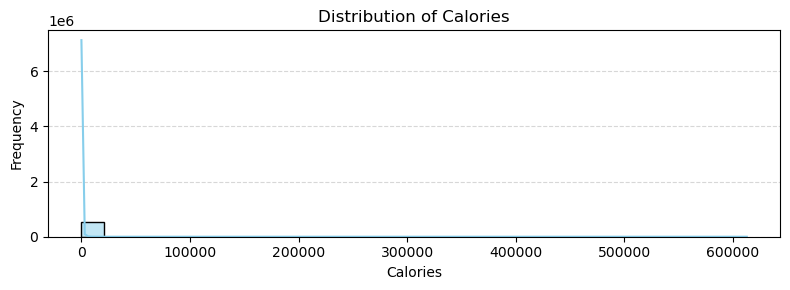

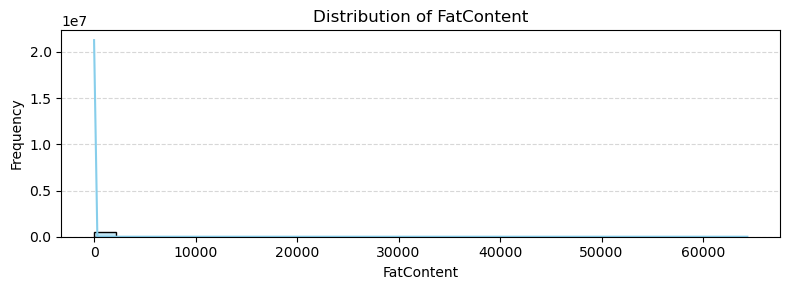

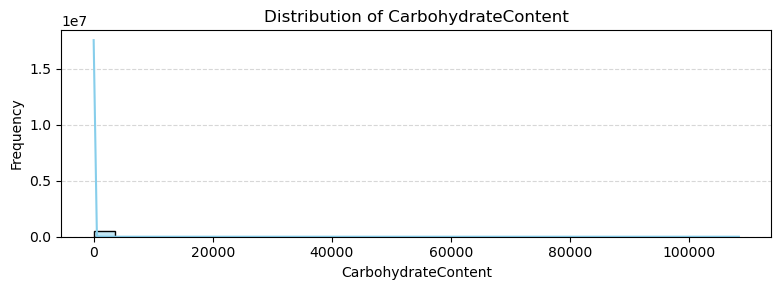

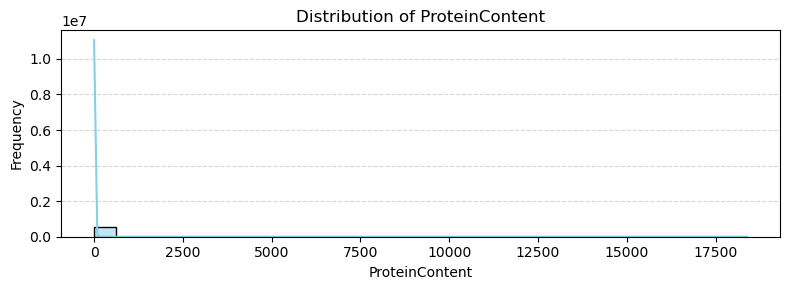

In [19]:
for col in nutrient_columns:
    plt.figure(figsize=(8, 3))  # Slightly taller for better visibility
    sns.histplot(recipes_df[col], kde=True, color='skyblue', bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

<div style="text-align: center;">
  <h1>Distribution of Allergy</h1>
</div>

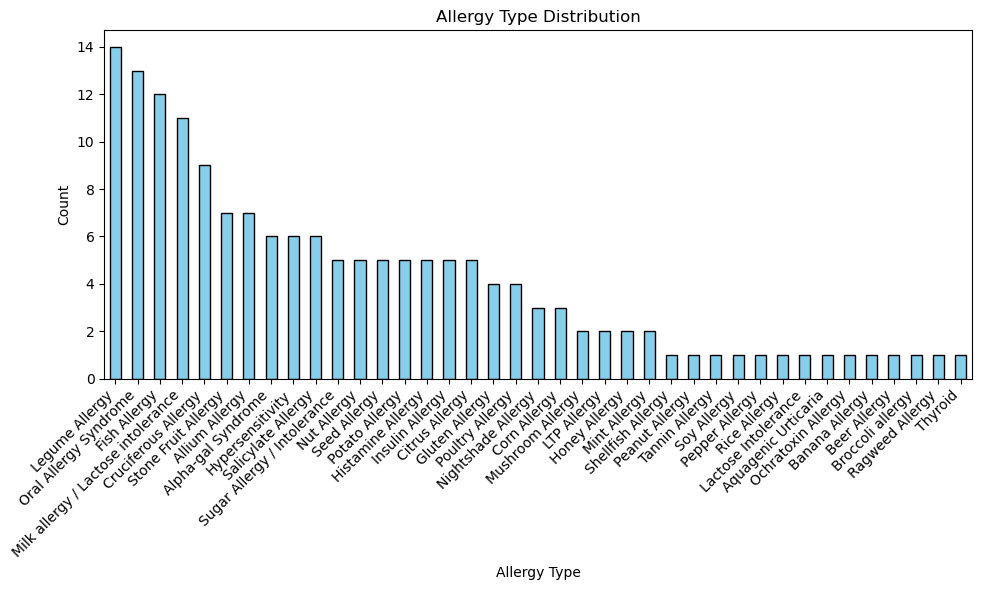

In [20]:
allergen_df['Allergy'].value_counts().plot(kind='bar', figsize=(10, 6), color='skyblue', edgecolor='black')
plt.title('Allergy Type Distribution')
plt.xlabel('Allergy Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<div style="text-align: center;">
  <h1>Outlier Detection</h1>
</div>

In [21]:
((recipes_df['Calories'] < 2000) & (recipes_df['Calories'] > 250)).sum()

304964

<div style="text-align: center;">
  <h1>Correlation Analysis</h1>
</div>

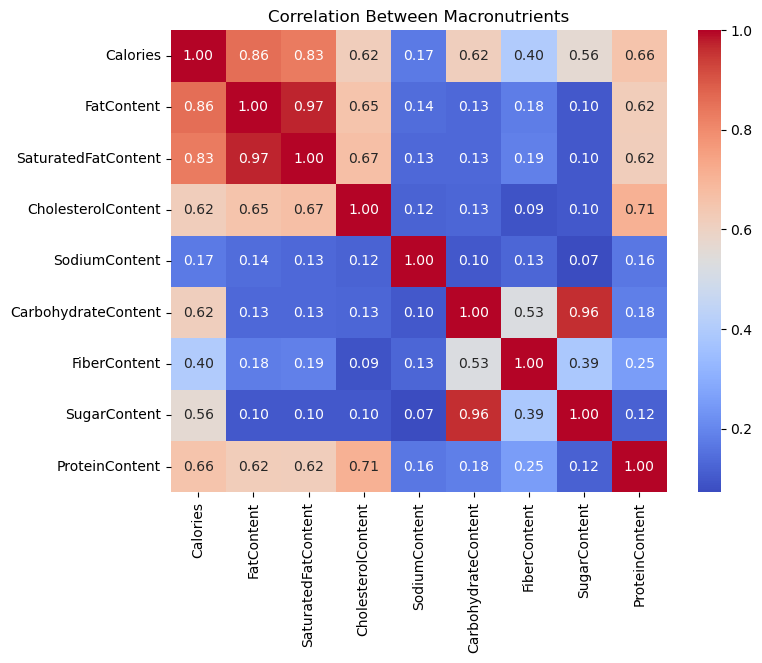

In [22]:
# Compute correlation matrix between macronutrients
correlation_matrix = recipes_df[['Calories', 'FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Macronutrients')
plt.show()

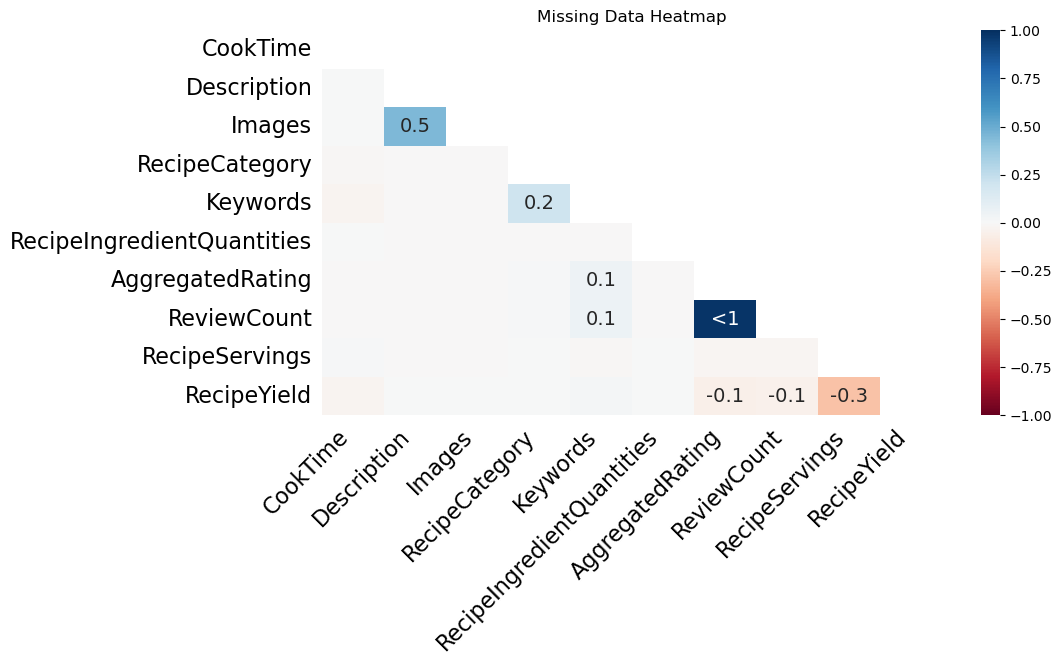

In [23]:
#Reveals relationships between missing values across columns
msno.heatmap(recipes_df, figsize=(10, 5))
plt.title("Missing Data Heatmap")
plt.show()

<div style="text-align: center;">
 <h1 style="color: #f39c12; font-size:64px">Data Preprocessing</h1>
</div>

In [24]:
filtered_columns = [
    'RecipeId',
    'Name',
    'Calories',
    'ProteinContent',
    'CarbohydrateContent',
    'FatContent',
    'RecipeCategory',
    'PrepTime',
    'CookTime',
    'TotalTime',
    'Images',
    'RecipeIngredientParts',
    'RecipeIngredientQuantities',
    'RecipeInstructions',
    'Keywords',
]

cleaned_recipes_df = recipes_df[filtered_columns]


<div style="text-align: center;">
  <h1>Handle missing values</h1>
</div>

In [ ]:
cleaned_recipes_df['CookTime'].fillna('NA', inplace=True) 
cleaned_recipes_df['Images'].fillna('None', inplace=True) 
cleaned_recipes_df['RecipeCategory'].fillna('NA', inplace=True) 
cleaned_recipes_df['Keywords'].fillna('NA', inplace=True)
cleaned_recipes_df['RecipeIngredientQuantities'].fillna('NA', inplace=True) 

allergen_df = allergen_df.dropna(subset=['Allergy'])

print("Recipes Dataset Info:")
cleaned_recipes_df.info()
print("\nAllergens Dataset Info:")
allergen_df.info()

C:\Users\Admin\AppData\Local\Temp\ipykernel_3288\2443500883.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_recipes_df['CookTime'].fillna('NA', inplace=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_3288\2443500883.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_recipes_df['CookTime'].fillna('NA', inplace=True)
C:\Us

Recipes Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 522517 entries, 0 to 522516
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   RecipeId                    522517 non-null  int64  
 1   Name                        522517 non-null  object 
 2   Calories                    522517 non-null  float64
 3   ProteinContent              522517 non-null  float64
 4   CarbohydrateContent         522517 non-null  float64
 5   FatContent                  522517 non-null  float64
 6   RecipeCategory              522517 non-null  object 
 7   PrepTime                    522517 non-null  object 
 8   CookTime                    522517 non-null  object 
 9   TotalTime                   522517 non-null  object 
 10  Images                      522517 non-null  object 
 11  RecipeIngredientParts       522517 non-null  object 
 12  RecipeIngredientQuantities  522517 non-null  objec

<div style="text-align: center;">
  <h1>Remove Outliers</h1>
</div>

In [ ]:
# Identify rows where all macronutrients = 0
all_macros_zero = (cleaned_recipes_df[macro_columns] == 0).all(axis=1)

# Keep only rows where NOT all macros are 0
cleaned_recipes_df = cleaned_recipes_df[~all_macros_zero].copy()

print(f"🧹 Removed rows: {all_macros_zero.sum()}")
print(f"✅ Remaining rows: {len(cleaned_recipes_df)}")

🧹 Removed rows: 4082
✅ Remaining rows: 518435


✅ Remaining rows: 304939


C:\Users\Admin\AppData\Local\Temp\ipykernel_3288\76172727.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleaned_recipes_df = cleaned_recipes_df[(recipes_df['Calories'] <= 2000) & (recipes_df['Calories'] >= 250)]


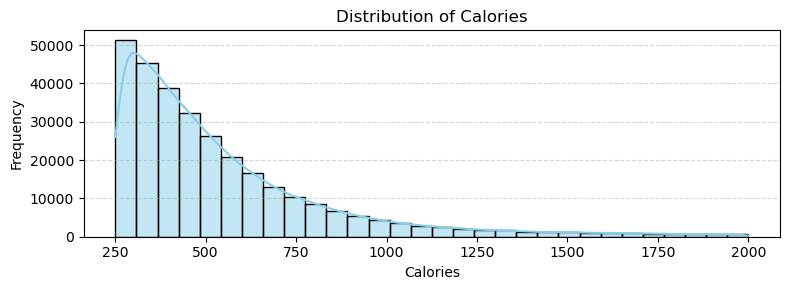

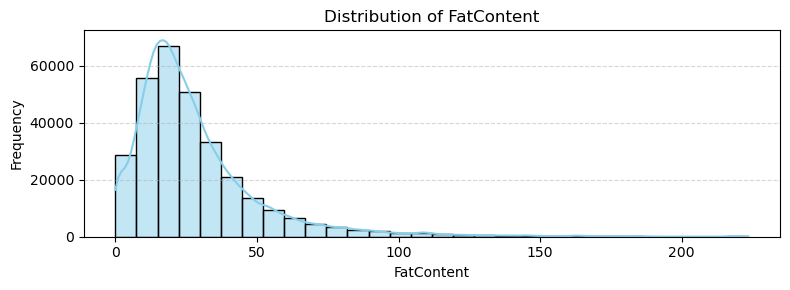

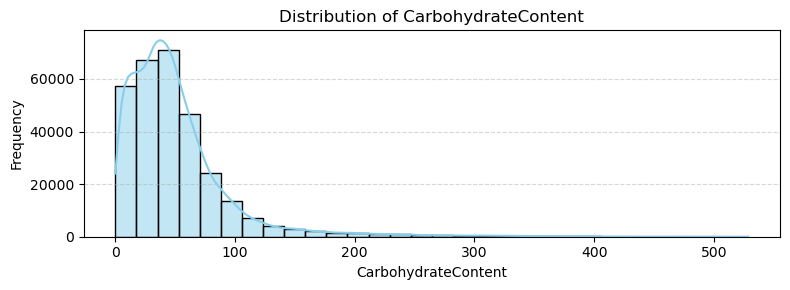

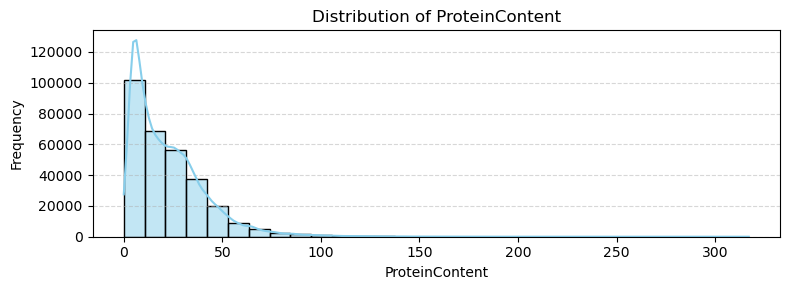

In [ ]:
cleaned_recipes_df = cleaned_recipes_df[(recipes_df['Calories'] <= 2000) & (recipes_df['Calories'] >= 250)]
print(f"✅ Remaining rows: {len(cleaned_recipes_df)}")

for col in nutrient_columns:
    plt.figure(figsize=(8, 3)) 
    sns.histplot(cleaned_recipes_df[col], kde=True, color='skyblue', bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
# Calculate total calories from macros
cleaned_recipes_df['Macro_Calories'] = (
    cleaned_recipes_df['CarbohydrateContent'] * 4 +
    cleaned_recipes_df['ProteinContent'] * 4 +
    cleaned_recipes_df['FatContent'] * 9
)

# Calculate macro calorie ratio vs reported calories
cleaned_recipes_df['Macro_Calorie_Ratio'] = (
    cleaned_recipes_df['Macro_Calories'] / cleaned_recipes_df['Calories']
)

# Keep rows where the macro calorie estimate is within 20% of reported calories
tolerance = 0.20
before = len(cleaned_recipes_df)
cleaned_recipes_df = cleaned_recipes_df[
    (cleaned_recipes_df['Macro_Calorie_Ratio'] >= (1 - tolerance)) &
    (cleaned_recipes_df['Macro_Calorie_Ratio'] <= (1 + tolerance))
].copy()
after = len(cleaned_recipes_df)

print(f"🧹 Removed rows with macro calories outside ±20% of reported calories: {before - after}")
print(f"✅ Remaining rows: {after}")

🧹 Removed rows with macro calories outside ±20% of reported calories: 3552
✅ Remaining rows: 301387


<div style="text-align: center;">
  <h1>Feature Engineering</h1>
</div>

In [29]:
# Step 2: Calculate Macro Percentages
# The percentage is computed as the calorie contribution of each macro divided by Total_Macro_Calories * 100
cleaned_recipes_df['Carb_%'] = cleaned_recipes_df['CarbohydrateContent'] * 4 / cleaned_recipes_df['Calories'] * 100
cleaned_recipes_df['Protein_%'] = cleaned_recipes_df['ProteinContent'] * 4 / cleaned_recipes_df['Calories'] * 100
cleaned_recipes_df['Fat_%'] = cleaned_recipes_df['FatContent'] * 9 / cleaned_recipes_df['Calories'] * 100

display(cleaned_recipes_df.head())


,RecipeId,Name,Calories,ProteinContent,CarbohydrateContent,FatContent,RecipeCategory,PrepTime,CookTime,TotalTime,Images,RecipeIngredientParts,RecipeIngredientQuantities,RecipeInstructions,Keywords,Macro_Calories,Macro_Calorie_Ratio,Carb_%,Protein_%,Fat_%
1,39,Biryani,1110.7,63.4,84.4,58.8,Chicken Breast,PT4H,PT25M,PT4H25M,"c(""https://img.sndimg.com/food/image/upload/w_...","c(""saffron"", ""milk"", ""hot green chili peppers""...","c(""1"", ""4"", ""2"", ""2"", ""8"", ""1/4"", ""8"", ""1/2"", ...","c(""Soak saffron in warm milk for 5 minutes and...","c(""Chicken Thigh & Leg"", ""Chicken"", ""Poultry"",...",1120.4,1.008733,30.395246,22.832448,47.645629
2,40,Best Lemonade,311.1,0.3,81.5,0.2,Beverages,PT30M,PT5M,PT35M,"c(""https://img.sndimg.com/food/image/upload/w_...","c(""sugar"", ""lemons, rind of"", ""lemon, zest of""...","c(""1 1/2"", ""1"", NA, ""1 1/2"", NA, ""3/4"")","c(""Into a 1 quart Jar with tight fitting lid, ...","c(""Low Protein"", ""Low Cholesterol"", ""Healthy"",...",329.0,1.057538,104.789457,0.385728,0.578592
3,41,Carina's Tofu-Vegetable Kebabs,536.1,29.3,64.2,24.0,Soy/Tofu,PT24H,PT20M,PT24H20M,"c(""https://img.sndimg.com/food/image/upload/w_...","c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...","c(""12"", ""1"", ""2"", ""1"", ""10"", ""1"", ""3"", ""2"", ""2...","c(""Drain the tofu, carefully squeezing out exc...","c(""Beans"", ""Vegetable"", ""Low Cholesterol"", ""We...",590.0,1.100541,47.901511,21.861593,40.290990
5,43,Best Blackbottom Pie,437.9,7.0,58.0,19.3,Pie,PT20M,PT2H,PT2H20M,character(0),"c(""graham cracker crumbs"", ""sugar"", ""butter"", ...","c(""1 1/4"", ""1/4"", ""6"", ""1/3"", ""1/4"", ""1/4"", ""2...","c(""Graham Cracker Crust: In small bowl, combin...","c(""Dessert"", ""Weeknight"", ""Stove Top"", ""< 4 Ho...",433.7,0.990409,52.980132,6.394154,39.666591
6,44,Warm Chicken A La King,895.5,45.3,29.1,66.8,Chicken,PT35M,PT3M,PT38M,"""https://img.sndimg.com/food/image/upload/w_55...","c(""chicken"", ""butter"", ""flour"", ""milk"", ""celer...","c(""12"", ""2"", ""3"", ""450"", ""1"", ""2"", ""1/4"", ""1"",...","c(""Melt 1 1/2 ozs butter, add the flour and co...","c(""Poultry"", ""Meat"", ""< 60 Mins"")",898.8,1.003685,12.998325,20.234506,67.135678


<div style="text-align: center;">
 <h1 style="color: #f39c12; font-size:64px">Data Integration</h1>
</div>

In [30]:
# Normalize relevant columns
cleaned_recipes_df['RecipeIngredientParts'] = cleaned_recipes_df['RecipeIngredientParts'].str.lower()
allergen_df['Food'] = allergen_df['Food'].str.lower()
allergen_df['Allergy'] = allergen_df['Allergy'].str.lower()

# Parse ingredients
def parse_ingredients(text):
    if pd.isna(text): return []
    cleaned = text.strip("c()").replace('"', '')
    return [i.strip() for i in cleaned.split(',')]

# Detect allergens from ingredient list
def detect_allergens(ingredient_list):
    allergens = set()
    for ing in ingredient_list:
        for _, row in allergen_df.iterrows():
            allergen_food = row['Food']
            allergy_type = row['Allergy']
            # Match whole word or part of word (e.g., "mushroom" in "shiitake mushroom")
            if re.search(rf'\b{re.escape(allergen_food)}\b', ing):
                allergens.add(allergy_type)
    return ', '.join(allergens) if allergens else None

# Apply detection
cleaned_recipes_df['AllergyType'] = cleaned_recipes_df['RecipeIngredientParts'].apply(lambda x: detect_allergens(parse_ingredients(x)))

cleaned_recipes_df[['Name', 'RecipeIngredientParts', 'AllergyType']].head(20)


,Name,RecipeIngredientParts,AllergyType
1,Biryani,"c(""saffron"", ""milk"", ""hot green chili peppers""...","citrus allergy, rice allergy, poultry allergy,..."
2,Best Lemonade,"c(""sugar"", ""lemons, rind of"", ""lemon, zest of""...","sugar allergy / intolerance, citrus allergy"
3,Carina's Tofu-Vegetable Kebabs,"c(""extra firm tofu"", ""eggplant"", ""zucchini"", ""...","citrus allergy, honey allergy, allium allergy"
5,Best Blackbottom Pie,"c(""graham cracker crumbs"", ""sugar"", ""butter"", ...","milk allergy / lactose intolerance, sugar alle..."
6,Warm Chicken A La King,"c(""chicken"", ""butter"", ""flour"", ""milk"", ""celer...","milk allergy / lactose intolerance, hypersensi..."
10,Boston Cream Pie,"c(""margarine"", ""cake flour"", ""baking powder"", ...","milk allergy / lactose intolerance, sugar alle..."
11,Chicken Breasts Lombardi,"c(""fresh mushrooms"", ""butter"", ""boneless skinl...","milk allergy / lactose intolerance, allium all..."
15,Jimmy G's Carrot Cake,"c(""all-purpose flour"", ""sugar"", ""baking powder...","oral allergy syndrome, sugar allergy / intoler..."
16,Carrot Cake,"c(""carrots"", ""eggs"", ""white sugar"", ""all-purpo...","milk allergy / lactose intolerance, sugar alle..."
17,Betty Crocker's Southwestern Guacamole Dip,"c(""avocados"", ""tomatoes"", ""salt"", ""garlic"", ""l...","citrus allergy, allium allergy"


<div style="text-align: center;">
  <h1>Data Transformation</h1>
</div>

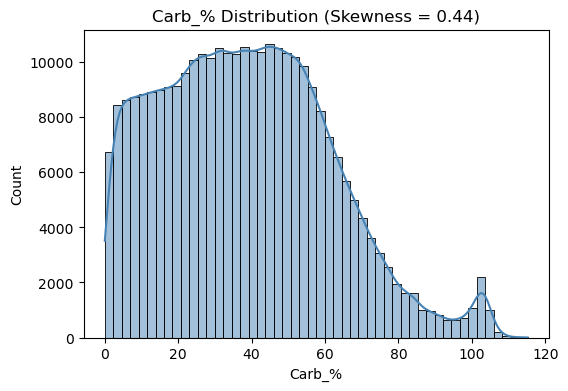

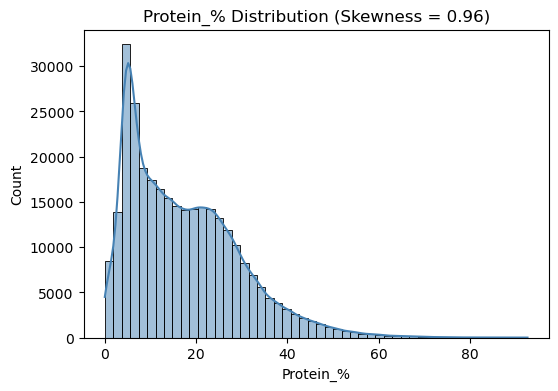

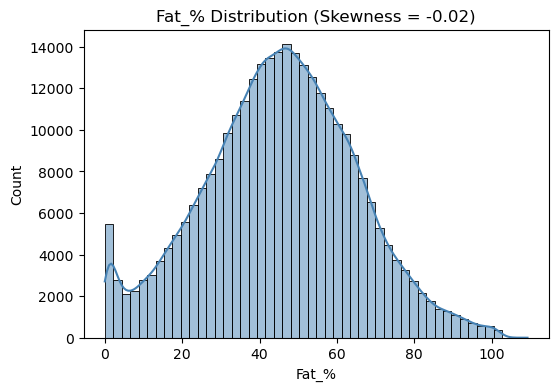

In [31]:
for col in ['Carb_%', 'Protein_%', 'Fat_%']:
    plt.figure(figsize=(6, 4))
    sns.histplot(cleaned_recipes_df[col], kde=True, bins=50, color='steelblue')
    skewness = skew(cleaned_recipes_df[col])
    plt.title(f'{col} Distribution (Skewness = {skewness:.2f})')
    plt.xlabel(col)
    plt.ylabel('Count') 
    plt.show()

,Carb_%_scaled,Protein_%_scaled,Fat_%_scaled
count,3.013870e+05,3.013870e+05,3.013870e+05
mean,-2.706261e-16,-1.406435e-15,1.282521e-17
std,1.000002e+00,1.000002e+00,1.000002e+00
min,-2.281302e+00,-2.544325e+00,-2.301635e+00
25%,-7.176089e-01,-8.318637e-01,-6.532737e-01
50%,7.994561e-02,4.926100e-02,1.954005e-02
75%,7.291045e-01,7.667498e-01,6.736222e-01
max,2.621540e+00,3.334001e+00,3.246788e+00


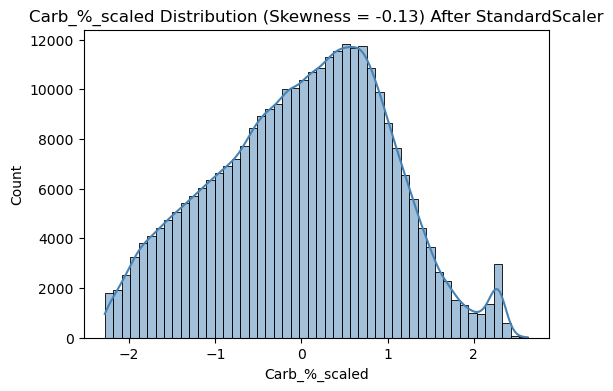

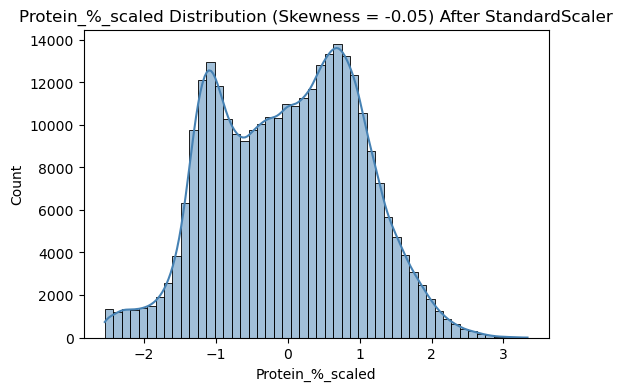

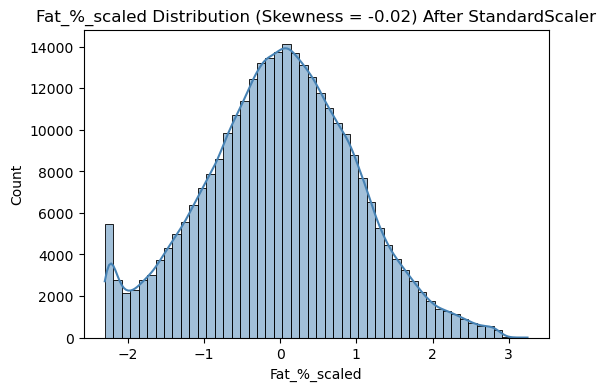

In [ ]:
transformed_df = cleaned_recipes_df.copy()

# Apply Yeo-Johnson Transformation to both Protein_% and Carb_%
pt_protein = PowerTransformer(method='yeo-johnson', standardize=False)
pt_carb = PowerTransformer(method='yeo-johnson', standardize=False)

# Transform and replace the original columns
transformed_df['Protein_%_scaled'] = pt_protein.fit_transform(transformed_df[['Protein_%']])
transformed_df['Carb_%_scaled'] = pt_carb.fit_transform(transformed_df[['Carb_%']])
transformed_df['Fat_%_scaled'] = transformed_df['Fat_%']


macro_percent_cols = ['Carb_%_scaled', 'Protein_%_scaled', 'Fat_%_scaled']

# Step 2: Standardize all macro percentage columns
scaler = StandardScaler()
transformed_df[macro_percent_cols] = scaler.fit_transform(transformed_df[macro_percent_cols])
display(transformed_df[macro_percent_cols].describe())


for col in macro_percent_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(transformed_df[col], kde=True, bins=50, color='steelblue')
    skewness = skew(transformed_df[col])
    plt.title(f'{col} Distribution (Skewness = {skewness:.2f}) After StandardScaler')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

<div style="text-align: center;">
  <h1>Anomaly Removal (must after stardardization)</h1>
</div>

🧪 Anomalies detected by IF: 3013
🧪 Anomalies detected by LOF: 3014
🧹 Anomalies detected by IF OR LOF: 302
✅ Final cleaned rows: 301085


,Name,CarbohydrateContent,ProteinContent,FatContent,IF_Anomaly,LOF_Anomaly
1008,Molasses Taffy,451.8,0.1,11.8,-1,-1
1507,Pickled Muskmelon,200.1,0.0,0.0,-1,-1
6988,Spiced Figs,150.1,0.0,0.1,-1,-1
8368,Root Beer Jelly,313.9,0.0,0.0,-1,-1
9048,Quince-Ginger Marmalade (Jam),116.6,0.0,0.0,-1,-1


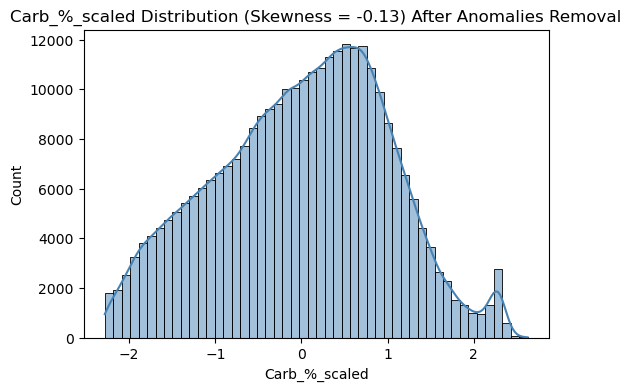

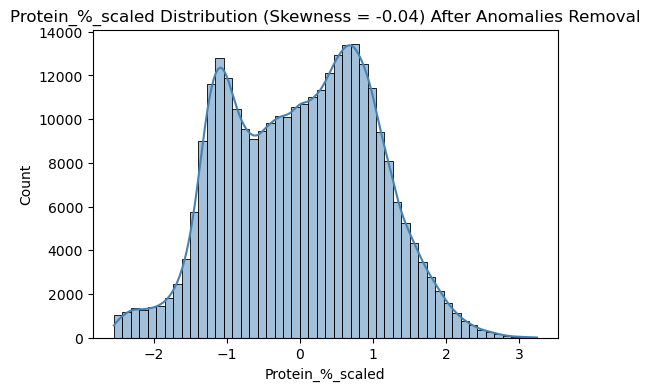

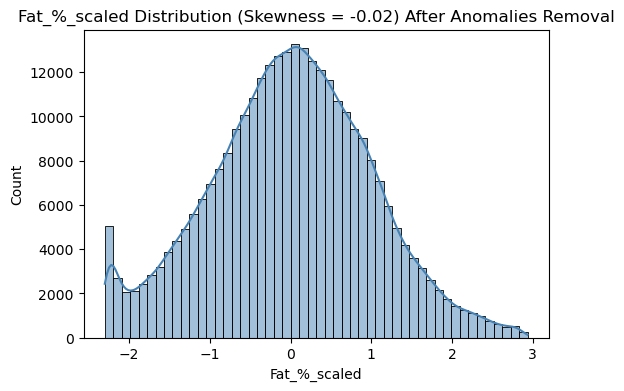

In [47]:
# Select relevant features
anomaly_X = transformed_df[macro_percent_cols].copy()

# Isolation Forest
iso = IsolationForest(contamination=0.01, random_state=42)
transformed_df['IF_Anomaly'] = iso.fit_predict(anomaly_X)  # -1 = outlier

# LOF
lof = LocalOutlierFactor(n_neighbors=100, contamination=0.01)
lof_preds = lof.fit_predict(anomaly_X)
transformed_df['LOF_Anomaly'] = lof_preds  # -1 = outlier


# Remove Anomaly (IF AND LOF)
transformed_df['Combined_Anomaly'] = (
    (transformed_df['IF_Anomaly'] == -1) &  
    (transformed_df['LOF_Anomaly'] == -1)
).astype(int)

# Remove combined anomaly (all anomaleis from IF AND LOF)
final_df = transformed_df[transformed_df['Combined_Anamoly'] == 0]

# Summary
print(f"🧪 Anomalies detected by IF: {(transformed_df['IF_Anomaly'] == -1).sum()}")
print(f"🧪 Anomalies detected by LOF: {(transformed_df['LOF_Anomaly'] == -1).sum()}")
print(f"🧹 Anomalies detected by IF OR LOF: {transformed_df['Combined_Anomaly'].sum()}")
print(f"✅ Final cleaned rows: {len(final_df)}")

final_df = final_df.drop(columns=['IF_Anomaly', 'LOF_Anomaly', 'Combined_Anomaly'])

display(
    transformed_df.loc[transformed_df['Combined_Anomaly'] == 1, 
                       ['Name', 'CarbohydrateContent', 'ProteinContent', 'FatContent', 'IF_Anomaly', 'LOF_Anomaly']].head()
)

for col in macro_percent_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(final_df[col], kde=True, bins=50, color='steelblue')
    skewness = skew(final_df[col])
    plt.title(f'{col} Distribution (Skewness = {skewness:.2f}) After Anomalies Removal')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

In [34]:
display(final_df.head())

,RecipeId,Name,Calories,ProteinContent,CarbohydrateContent,FatContent,RecipeCategory,PrepTime,CookTime,TotalTime,...,Keywords,Macro_Calories,Macro_Calorie_Ratio,Carb_%,Protein_%,Fat_%,AllergyType,Protein_%_scaled,Carb_%_scaled,Fat_%_scaled
1,39,Biryani,1110.7,63.4,84.4,58.8,Chicken Breast,PT4H,PT25M,PT4H25M,...,"c(""Chicken Thigh & Leg"", ""Chicken"", ""Poultry"",...",1120.4,1.008733,30.395246,22.832448,47.645629,"citrus allergy, rice allergy, poultry allergy,...",0.635894,-0.220203,0.117605
2,40,Best Lemonade,311.1,0.3,81.5,0.2,Beverages,PT30M,PT5M,PT35M,...,"c(""Low Protein"", ""Low Cholesterol"", ""Healthy"",...",329.0,1.057538,104.789457,0.385728,0.578592,"sugar allergy / intolerance, citrus allergy",-2.342840,2.335848,-2.272257
3,41,Carina's Tofu-Vegetable Kebabs,536.1,29.3,64.2,24.0,Soy/Tofu,PT24H,PT20M,PT24H20M,...,"c(""Beans"", ""Vegetable"", ""Low Cholesterol"", ""We...",590.0,1.100541,47.901511,21.861593,40.290990,"citrus allergy, honey allergy, allium allergy",0.570579,0.503820,-0.255832
5,43,Best Blackbottom Pie,437.9,7.0,58.0,19.3,Pie,PT20M,PT2H,PT2H20M,...,"c(""Dessert"", ""Weeknight"", ""Stove Top"", ""< 4 Ho...",433.7,0.990409,52.980132,6.394154,39.666591,"milk allergy / lactose intolerance, sugar alle...",-0.913456,0.693487,-0.287536
6,44,Warm Chicken A La King,895.5,45.3,29.1,66.8,Chicken,PT35M,PT3M,PT38M,...,"c(""Poultry"", ""Meat"", ""< 60 Mins"")",898.8,1.003685,12.998325,20.234506,67.135678,"milk allergy / lactose intolerance, hypersensi...",0.456702,-1.130237,1.107226


<div style="text-align: center;">
 <h1 style="color: #f39c12; font-size:64px">Modeling</h1>
</div>

<div style="text-align: center;">
  <h1>GMM</h1>
</div>

<Figure size 1000x600 with 0 Axes>

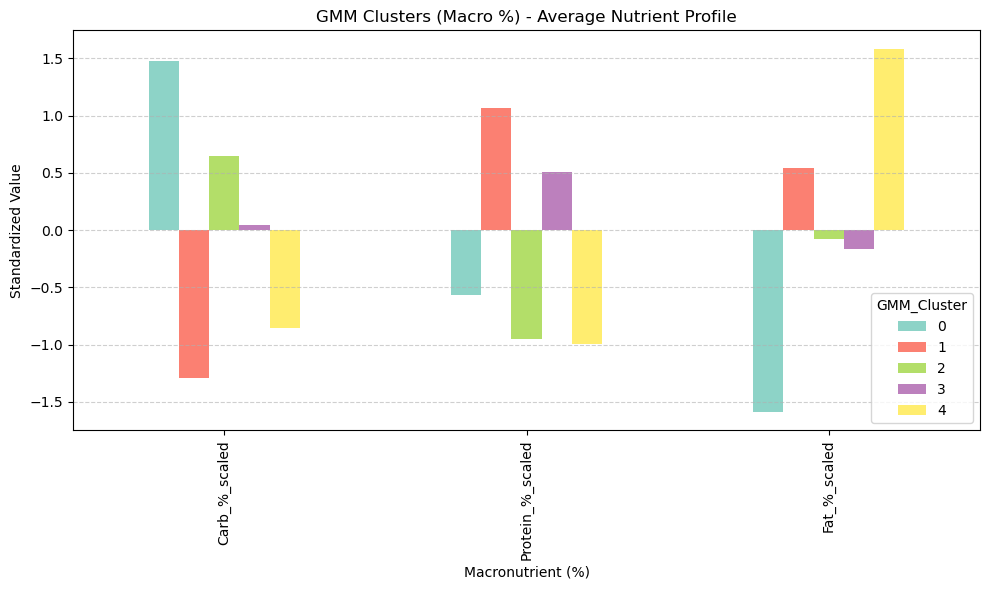

In [102]:
# Use macro percentages instead of absolute grams
gmm_df = final_df.copy()
gmm_X = final_df[macro_percent_cols].copy()

# Train GMM model with macro percentages
gmm = GaussianMixture(n_components=5, random_state=42)
gmm.fit(gmm_X)

# Predict clusters
gmm_df['GMM_Cluster'] = gmm.predict(gmm_X)

# Compute cluster means
cluster_means = gmm_df.groupby('GMM_Cluster')[macro_percent_cols].mean()

# Plot cluster means
plt.figure(figsize=(10, 6))
cluster_means.T.plot(kind='bar', figsize=(10, 6), colormap='Set3')
plt.title("GMM Clusters (Macro %) - Average Nutrient Profile")
plt.ylabel("Standardized Value")
plt.xlabel("Macronutrient (%)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [101]:
# Define parameter ranges
n_range = range(3, 8)
cov_types = ['full', 'tied', 'diag', 'spherical']

# Run GMM tuning for all combinations
gmm_results = []
print("🔍 Running GMM hyperparameter tuning...")
for cov in cov_types:
    for n in n_range:
        gmm = GaussianMixture(n_components=n, covariance_type=cov, random_state=42)
        gmm.fit(gmm_X)

        labels = gmm.predict(gmm_X)

        # Metrics
        dbi_score = davies_bouldin_score(gmm_X, labels)
        ch_score = calinski_harabasz_score(gmm_X, labels)
        bic_score = gmm.bic(gmm_X)

        gmm_results.append({
            'n_components': n,
            'covariance_type': cov,
            'davies_bouldin_index': dbi_score,
            'calinski_harabasz': ch_score,
            'bic': bic_score
        })

        print(f"n={n}, cov={cov} ➤ DBI={dbi_score:.4f}, CH={ch_score:.2f}, BIC={bic_score:.2f}")

# Convert results to DataFrame
gmm_results_df = pd.DataFrame(gmm_results)

🔍 Running GMM hyperparameter tuning...
n=3, cov=full ➤ DBI=0.9604, CH=146283.02, BIC=1435931.95
n=4, cov=full ➤ DBI=1.0110, CH=138290.72, BIC=1367245.70
n=5, cov=full ➤ DBI=1.0376, CH=141298.48, BIC=1273047.56
n=6, cov=full ➤ DBI=1.0613, CH=146219.63, BIC=1252671.11
n=7, cov=full ➤ DBI=1.0719, CH=137137.76, BIC=1214821.85
n=3, cov=tied ➤ DBI=1.3033, CH=124406.92, BIC=1685232.67
n=4, cov=tied ➤ DBI=1.5407, CH=98294.35, BIC=1608654.45
n=5, cov=tied ➤ DBI=1.0568, CH=88799.28, BIC=1543655.49
n=6, cov=tied ➤ DBI=1.3556, CH=82149.90, BIC=1496831.84
n=7, cov=tied ➤ DBI=1.5330, CH=72067.04, BIC=1451827.94
n=3, cov=diag ➤ DBI=0.9284, CH=204342.92, BIC=2291467.94
n=4, cov=diag ➤ DBI=1.0158, CH=198285.30, BIC=2171415.89
n=5, cov=diag ➤ DBI=0.9167, CH=214311.97, BIC=2108360.93
n=6, cov=diag ➤ DBI=0.9216, CH=205634.97, BIC=2055125.01
n=7, cov=diag ➤ DBI=0.8587, CH=206692.46, BIC=1999996.70
n=3, cov=spherical ➤ DBI=0.9182, CH=204449.55, BIC=2322007.47
n=4, cov=spherical ➤ DBI=0.9773, CH=197936.64, B

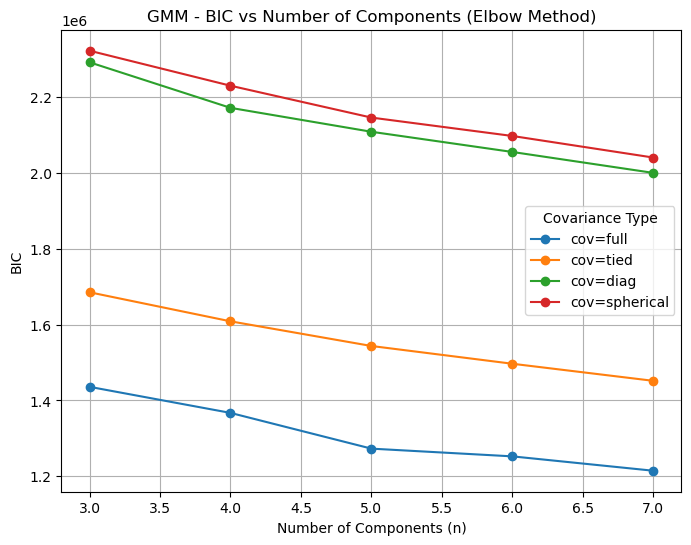

In [107]:
plt.figure(figsize=(8,6))
for cov in cov_types:
    subset = gmm_results_df[gmm_results_df['covariance_type'] == cov]
    plt.plot(
        subset['n_components'],
        subset['bic'],
        'o-',
        label=f'cov={cov}'
    )
plt.title('GMM - BIC vs Number of Components (Elbow Method)')
plt.xlabel('Number of Components (n)')
plt.ylabel('BIC')
plt.legend(title='Covariance Type')
plt.grid(True)
plt.show()


In [76]:
# Set your chosen config
best_n = 9
best_cov = 'spherical'

# Fit model with selected config
best_gmm = GaussianMixture(n_components=best_n, covariance_type=best_cov, random_state=42)
best_gmm.fit(gmm_X)

# Get soft cluster assignments
soft_probs = best_gmm.predict_proba(gmm_X)

# Convert to a DataFrame for easier handling
proba_df = pd.DataFrame(soft_probs, columns=[f'Cluster_{i}_Prob' for i in range(best_gmm.n_components)])

# Optionally join it back to your original DataFrame
gmm_soft_df = pd.concat([gmm_df.reset_index(drop=True), proba_df], axis=1)

# Preview
gmm_soft_df.head()


,RecipeId,Name,Calories,ProteinContent,CarbohydrateContent,FatContent,RecipeCategory,PrepTime,CookTime,TotalTime,...,GMM_Cluster,Cluster_0_Prob,Cluster_1_Prob,Cluster_2_Prob,Cluster_3_Prob,Cluster_4_Prob,Cluster_5_Prob,Cluster_6_Prob,Cluster_7_Prob,Cluster_8_Prob
0,39,Biryani,1110.7,63.4,84.4,58.8,Chicken Breast,PT4H,PT25M,PT4H25M,...,3,5.443383e-08,1.230275e-03,4.451348e-05,9.816430e-01,8.944316e-07,4.070255e-03,1.632335e-06,1.300940e-02,1.044820e-19
1,40,Best Lemonade,311.1,0.3,81.5,0.2,Beverages,PT30M,PT5M,PT35M,...,0,1.450811e-08,1.452195e-44,8.653924e-27,1.812283e-38,2.285585e-13,5.593143e-29,6.943086e-22,6.657677e-19,1.000000e+00
2,41,Carina's Tofu-Vegetable Kebabs,536.1,29.3,64.2,24.0,Soy/Tofu,PT24H,PT20M,PT24H20M,...,0,1.370140e-03,6.131482e-07,1.906918e-05,2.006208e-01,5.641765e-04,4.326015e-04,4.992083e-08,7.969925e-01,1.611635e-13
3,43,Best Blackbottom Pie,437.9,7.0,58.0,19.3,Pie,PT20M,PT2H,PT2H20M,...,2,5.604159e-04,2.522742e-12,1.586614e-03,1.758208e-06,9.978184e-01,2.343729e-10,1.459844e-07,3.262389e-05,4.598748e-08
4,44,Warm Chicken A La King,895.5,45.3,29.1,66.8,Chicken,PT35M,PT3M,PT38M,...,1,1.687277e-17,9.949585e-01,1.971481e-05,1.896577e-03,7.682308e-13,6.481807e-04,2.477047e-03,2.938172e-08,9.073058e-31


<div style="text-align: center;">
  <h1>K-means</h1>
</div>

<Figure size 1000x600 with 0 Axes>

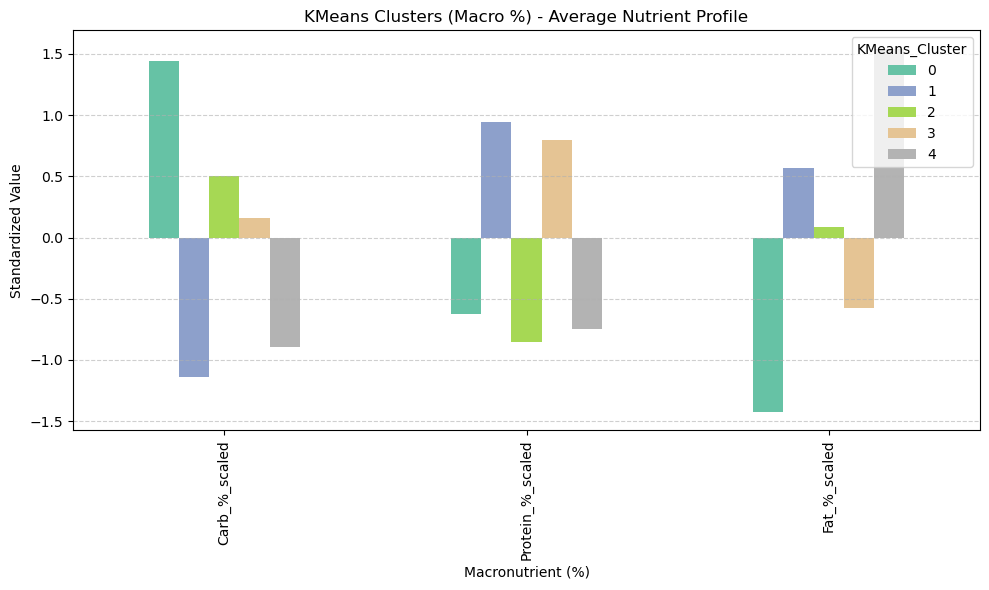

In [37]:
standard_kmeans_df = final_df.copy()
standard_kmeans_X = final_df[macro_percent_cols].copy()


# Train KMeans model
standard_kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
standard_kmeans.fit(standard_kmeans_X)

# Assign clusters
standard_kmeans_df['KMeans_Cluster'] = standard_kmeans.predict(standard_kmeans_X)

# Compute cluster means
cluster_means_kmeans = standard_kmeans_df.groupby('KMeans_Cluster')[macro_percent_cols].mean()

# Plot
plt.figure(figsize=(10, 6))
cluster_means_kmeans.T.plot(kind='bar', figsize=(10, 6), colormap='Set2')
plt.title("KMeans Clusters (Macro %) - Average Nutrient Profile")
plt.ylabel("Standardized Value")
plt.xlabel("Macronutrient (%)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [98]:
standard_kmeans_results = []

# Choose cluster range
k_range = range(3, 8)

print("🔍 Running KMeans (StandardScaler) hyperparameter tuning...")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(standard_kmeans_X)
    dbi = davies_bouldin_score(standard_kmeans_X, labels)
    ch_score = calinski_harabasz_score(standard_kmeans_X, labels)
    inertia = kmeans.inertia_

    standard_kmeans_results.append({
        'k': k,
        'davies_bouldin_index': dbi,
        'calinski_harabasz': ch_score,
        'inertia': inertia
    })

    print(f"k={k} ➤ DBI={dbi:.4f}, CH={ch_score:.2f}, Inertia={inertia:.2f}")

# Results as DataFrame
standard_kmeans_results_df = pd.DataFrame(standard_kmeans_results)

🔍 Running KMeans (StandardScaler) hyperparameter tuning...
k=3 ➤ DBI=0.9607, CH=210199.20, Inertia=375177.19
k=4 ➤ DBI=0.9478, CH=207047.34, Inertia=293511.89
k=5 ➤ DBI=0.8757, CH=222435.24, Inertia=227306.92
k=6 ➤ DBI=0.8941, CH=214951.86, Inertia=196739.15
k=7 ➤ DBI=0.8285, CH=218473.92, Inertia=167923.19


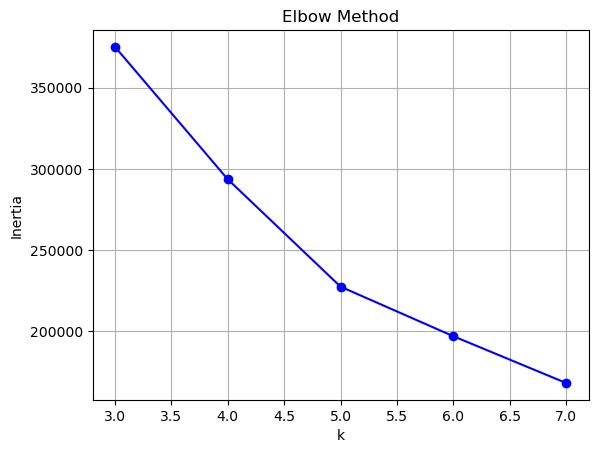

In [108]:
plt.plot([r['k'] for r in standard_kmeans_results], [r['inertia'] for r in standard_kmeans_results], 'o-', color='blue')
plt.title('Elbow Method')
plt.xlabel('k'), plt.ylabel('Inertia')
plt.grid(True)
plt.show()

<div style="text-align: center;">
  <h1>Mini Batch K-means</h1>
</div>

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1972: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

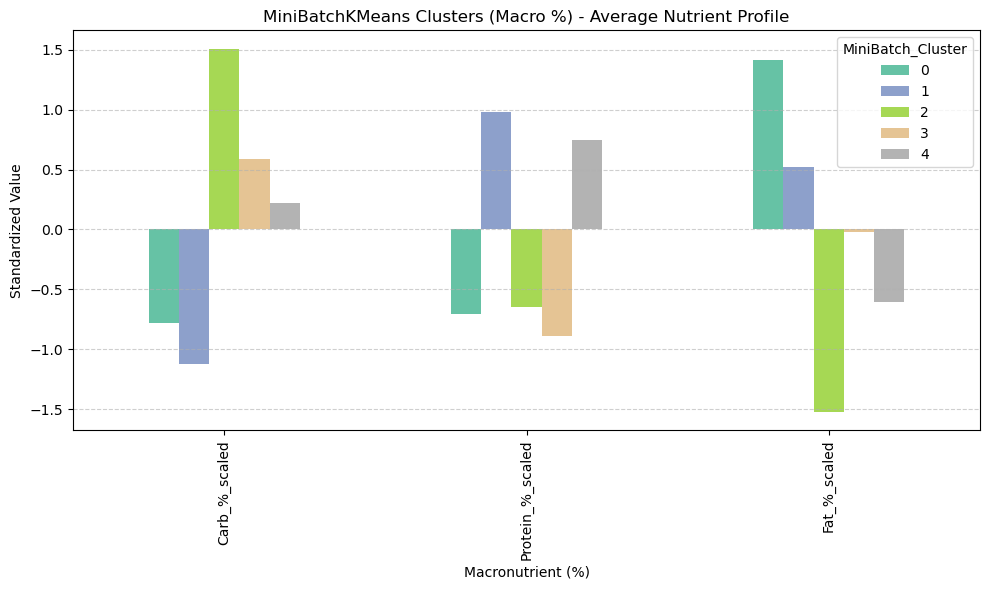

In [39]:
standard_minibatch_df = final_df.copy()
standard_minibatch_X = final_df[macro_percent_cols].copy()

# Train MiniBatchKMeans model
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42, batch_size=1000, n_init='auto')
minibatch_kmeans.fit(standard_minibatch_X)

# Assign clusters
standard_minibatch_df['MiniBatch_Cluster'] = minibatch_kmeans.predict(standard_minibatch_X)

# Compute cluster means
cluster_means_minibatch = standard_minibatch_df.groupby('MiniBatch_Cluster')[macro_percent_cols].mean()

# Plot
plt.figure(figsize=(10, 6))
cluster_means_minibatch.T.plot(kind='bar', figsize=(10, 6), colormap='Set2')
plt.title("MiniBatchKMeans Clusters (Macro %) - Average Nutrient Profile")
plt.ylabel("Standardized Value")
plt.xlabel("Macronutrient (%)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [89]:
k_range = range(3, 8)
standard_minibatch_results = []

print("🔍 Running MiniBatchKMeans (StandardScaler) hyperparameter tuning...")

for k in k_range:
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=2048, n_init='auto')
    labels = minibatch_kmeans.fit_predict(standard_minibatch_X)
    dbi = davies_bouldin_score(standard_minibatch_X, labels)
    ch_score = calinski_harabasz_score(standard_minibatch_X, labels)
    inertia = minibatch_kmeans.inertia_


    standard_minibatch_results.append({
        'k': k,
        'davies_bouldin_index': dbi,
        'calinski_harabasz': ch_score,
        'inertia': inertia
    })

    print(f"k={k} ➤ DBI={dbi:.4f}, CH={ch_score:.2f}, Inertia={inertia:.2f}")

standard_minibatch_results_df = pd.DataFrame(standard_minibatch_results)

🔍 Running MiniBatchKMeans (StandardScaler) hyperparameter tuning...
k=3 ➤ DBI=0.9660, CH=200905.38, Inertia=386516.11
k=4 ➤ DBI=0.9641, CH=206853.73, Inertia=293838.52
k=5 ➤ DBI=0.8969, CH=211554.32, Inertia=237156.37
k=6 ➤ DBI=0.9235, CH=211620.03, Inertia=199424.70
k=7 ➤ DBI=0.8687, CH=212639.42, Inertia=172082.46


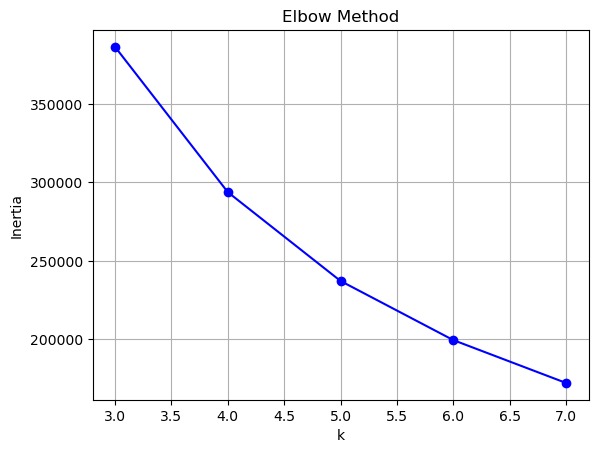

In [109]:
plt.plot([r['k'] for r in standard_minibatch_results], [r['inertia'] for r in standard_minibatch_results], 'o-', color='blue')
plt.title('Elbow Method')
plt.xlabel('k'), plt.ylabel('Inertia')
plt.grid(True)
plt.show()

<div style="text-align: center;">
  <h1>MinMaxScaler</h1>
</div>

✅ Final number of rows in minmax_df: 301085


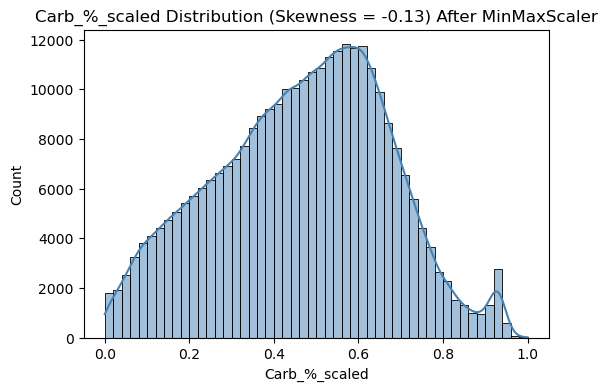

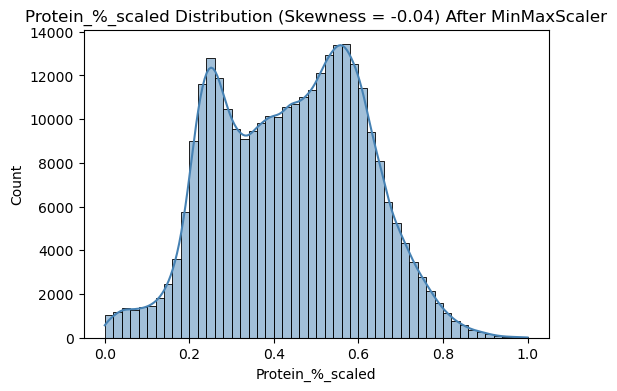

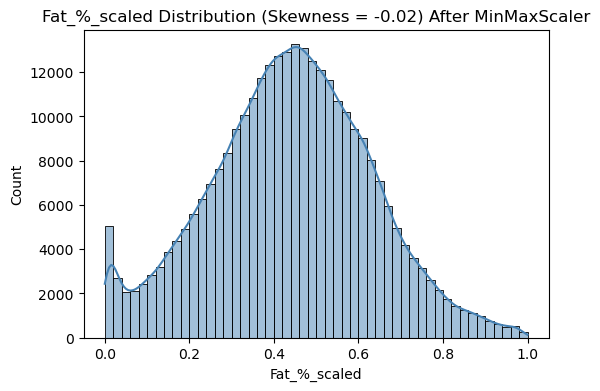

In [41]:
# Step 1: Refit StandardScaler on the SAME data used before outlier removal
std_scaler = StandardScaler()
std_scaler.fit(transformed_df[macro_percent_cols])  # this is the pre-outlier dataframe

# Step 2: Reverse StandardScaler on final_df (which has standardized values)
unscaled_df = final_df.copy()
unscaled_values = std_scaler.inverse_transform(unscaled_df[macro_percent_cols])
unscaled_df[macro_percent_cols] = unscaled_values

# Step 3: Apply MinMaxScaler
minmax_scaler = MinMaxScaler()
minmax_scaled = minmax_scaler.fit_transform(unscaled_df[macro_percent_cols])

# Step 4: Create final DataFrame with MinMax-scaled features
minmax_df = unscaled_df.copy()
minmax_df[macro_percent_cols] = minmax_scaled

print(f"✅ Final number of rows in minmax_df: {len(minmax_df)}")

for col in macro_percent_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(minmax_df[col], kde=True, bins=50, color='steelblue')
    skewness = skew(minmax_df[col])
    plt.title(f'{col} Distribution (Skewness = {skewness:.2f}) After MinMaxScaler')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()


<div style="text-align: center;">
  <h1>SOM (MINMAX)</h1>
</div>

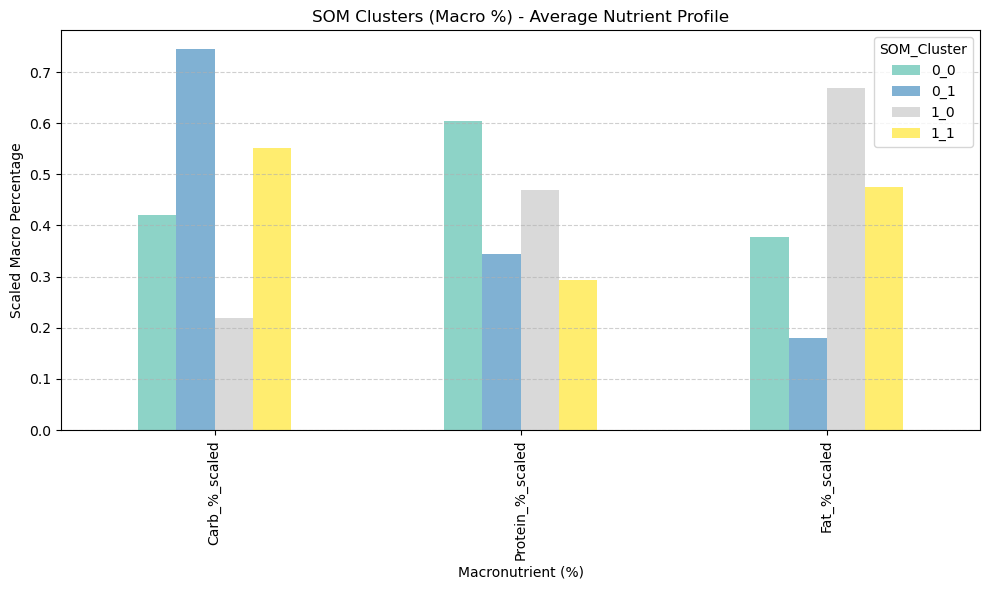

In [ ]:
som_df = minmax_df.copy()
som_X = minmax_df[macro_percent_cols].values.copy()

# Initialize SOM
grid_x, grid_y = 2, 2  # 3x2 grid = 6 clusters
som = MiniSom(x=grid_x, y=grid_y, input_len=som_X.shape[1], sigma=1.0, learning_rate=0.05, random_seed=42)

# Train SOM
som.train_random(som_X, num_iteration=2000)

# Get the winning node (BMU) for each sample
win_map = np.array([som.winner(x) for x in som_X])
som_cluster_labels = [f"{x}_{y}" for x, y in win_map]

# Add cluster labels to DataFrame
som_df['SOM_Cluster'] = som_cluster_labels

# Compute average macro % per SOM cluster
som_cluster_means = som_df.groupby('SOM_Cluster')[macro_percent_cols].mean()

# Transpose and plot
ax = som_cluster_means.T.plot(kind='bar', figsize=(10, 6), colormap='Set3')

# Optional: Add value labels on bars
plt.title("SOM Clusters (Macro %) - Average Nutrient Profile")
plt.ylabel("Scaled Macro Percentage")
plt.xlabel("Macronutrient (%)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [ ]:
# Grid sizes to test
grid_sizes = [(2, 2), (3, 2), (3, 3)]

som_results = []

print("🔍 Running SOM grid tuning...")

for x, y in grid_sizes:
    
    # Initialize and train SOM
    som = MiniSom(x=x, y=y, input_len=som_X.shape[1], sigma=1.0, learning_rate=0.05, random_seed=42)
    som.train_random(som_X, num_iteration=2000)

    # Compute Quantization Error
    q_error = som.quantization_error(som_X)

    # Get BMU coordinates and label them
    bmu_coords = np.array([som.winner(xi) for xi in som_X])
    bmu_labels = [f"{i}_{j}" for i, j in bmu_coords]

    # Encode to integer labels for metrics
    le = LabelEncoder()
    bmu_labels_int = le.fit_transform(bmu_labels)

    # Count how many samples in each cluster
    unique, counts = np.unique(bmu_labels_int, return_counts=True)

    # Initialize metric scores
    sil_score = np.nan
    ch_score = np.nan
    dbi_score = np.nan

    # Check for valid clustering structure
    if np.any(counts < 2):
        print("⚠️ Some clusters have <2 samples, filtering...")

        valid_clusters = [label for label, count in zip(unique, counts) if count >= 2]
        valid_indices = [i for i, label in enumerate(bmu_labels_int) if label in valid_clusters]

        if len(valid_clusters) >= 2:
            filtered_X = som_X[valid_indices]
            filtered_labels = np.array(bmu_labels_int)[valid_indices]

            dbi_score = davies_bouldin_score(filtered_X, filtered_labels)
            ch_score = calinski_harabasz_score(filtered_X, filtered_labels)
        else:
            print("❌ Not enough valid clusters even after filtering.")
    else:
        dbi_score = davies_bouldin_score(som_X, bmu_labels_int)
        ch_score = calinski_harabasz_score(som_X, bmu_labels_int)


    # Save results
    som_results.append({
        'grid_x': x,
        'grid_y': y,
        'clusters': x * y,
        'quantization_error': q_error,
        'davies_bouldin_index': dbi_score,
        'calinski_harabasz': ch_score
    })

    print(f"✅ Grid: {x}x{y} ➤ Clusters: {x * y}, QE: {q_error:.4f}, "
          f"DBI: {dbi_score:.4f}, CH: {ch_score:.2f}")

# Convert results to DataFrame
som_results_df = pd.DataFrame(som_results)


🔍 Running SOM grid tuning...
✅ Grid: 2x2 ➤ Clusters: 4, QE: 0.1669, DBI: 0.9042, CH: 215613.22
✅ Grid: 3x2 ➤ Clusters: 6, QE: 0.1377, DBI: 0.8763, CH: 217632.66
✅ Grid: 3x3 ➤ Clusters: 9, QE: 0.1147, DBI: 0.9111, CH: 209228.30


<div style="text-align: center;">
  <h1>K-means (MINMAX)</h1>
</div>

<Figure size 1000x600 with 0 Axes>

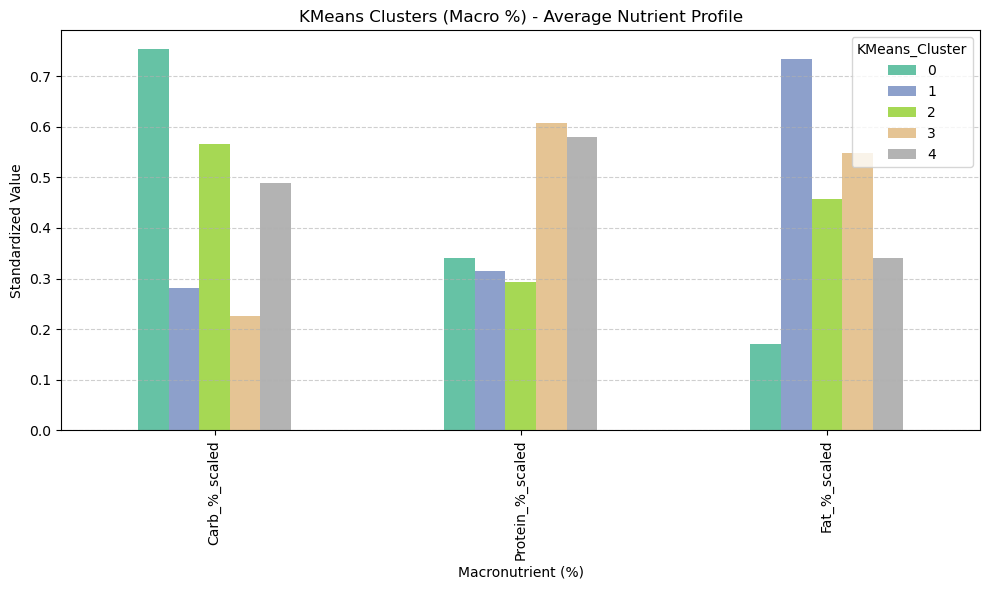

In [104]:
minmax_kmeans_df = minmax_df.copy()
minmax_kmeans_X = minmax_df[macro_percent_cols].copy()


# Train KMeans model
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
kmeans.fit(minmax_kmeans_X)

# Assign clusters
minmax_kmeans_df['KMeans_Cluster'] = kmeans.predict(minmax_kmeans_X)

# Compute cluster means
cluster_means_kmeans = minmax_kmeans_df.groupby('KMeans_Cluster')[macro_percent_cols].mean()

# Plot
plt.figure(figsize=(10, 6))
cluster_means_kmeans.T.plot(kind='bar', figsize=(10, 6), colormap='Set2')
plt.title("KMeans Clusters (Macro %) - Average Nutrient Profile")
plt.ylabel("Standardized Value")
plt.xlabel("Macronutrient (%)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [105]:
joblib.dump(kmeans, 'kmeans_model.pkl')
joblib.dump(minmax_scaler, "scaler.pkl")

minmax_kmeans_df.to_csv("recipes.csv", index=False)

In [81]:
k_range = range(3, 8)
minmax_kmeans_results = []

print("🔍 Running KMeans (MinMaxScaler) hyperparameter tuning...")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(minmax_kmeans_X)
    dbi = davies_bouldin_score(minmax_kmeans_X, labels)
    ch_score = calinski_harabasz_score(minmax_kmeans_X, labels)
    inertia = kmeans.inertia_

    minmax_kmeans_results.append({
        'k': k,
        'davies_bouldin_index': dbi,
        'calinski_harabasz': ch_score,
        'inertia': inertia
    })

    print(f"k={k} ➤ DBI={dbi:.4f}, CH={ch_score:.2f}, Inertia={inertia:.2f}")

minmax_kmeans_results_df = pd.DataFrame(minmax_kmeans_results)

🔍 Running KMeans (MinMaxScaler) hyperparameter tuning...
k=3 ➤ DBI=0.9944, CH=214071.90, Inertia=13360.06
k=4 ➤ DBI=0.9416, CH=218624.75, Inertia=10180.77
k=5 ➤ DBI=0.8723, CH=230785.78, Inertia=7958.09
k=6 ➤ DBI=0.8939, CH=222931.49, Inertia=6881.52
k=7 ➤ DBI=0.8362, CH=224119.29, Inertia=5919.56


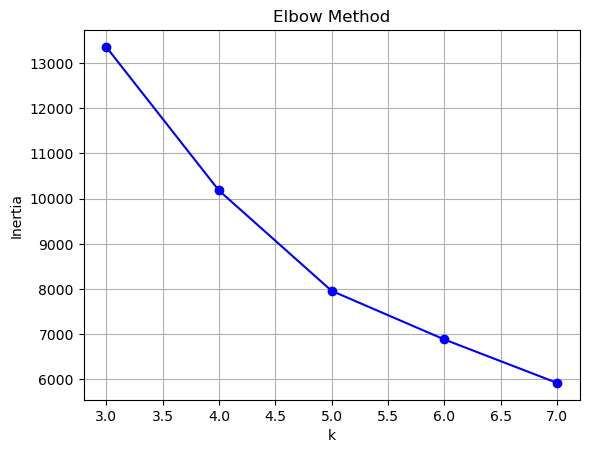

In [103]:
plt.plot([r['k'] for r in minmax_kmeans_results], [r['inertia'] for r in minmax_kmeans_results], 'o-', color='blue')
plt.title('Elbow Method')
plt.xlabel('k'), plt.ylabel('Inertia')
plt.grid(True)
plt.show()

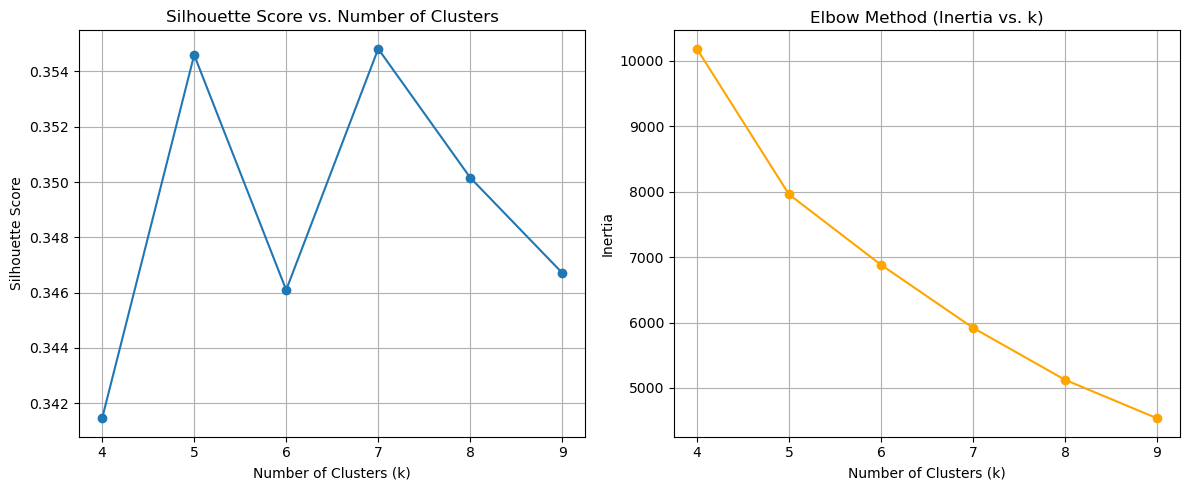

In [ ]:
# Plot results
plt.figure(figsize=(12, 5))


# Inertia Plot (Elbow)
plt.subplot(1, 2, 2)
plt.plot(k_range, minmax_inertias, marker='o', color='orange', label='Inertia')
plt.title("Elbow Method (Inertia vs. k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)

plt.tight_layout()
plt.show()

<div style="text-align: center;">
  <h1>Mini Batch K-means (MINMAX)</h1>
</div>

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1972: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1536 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

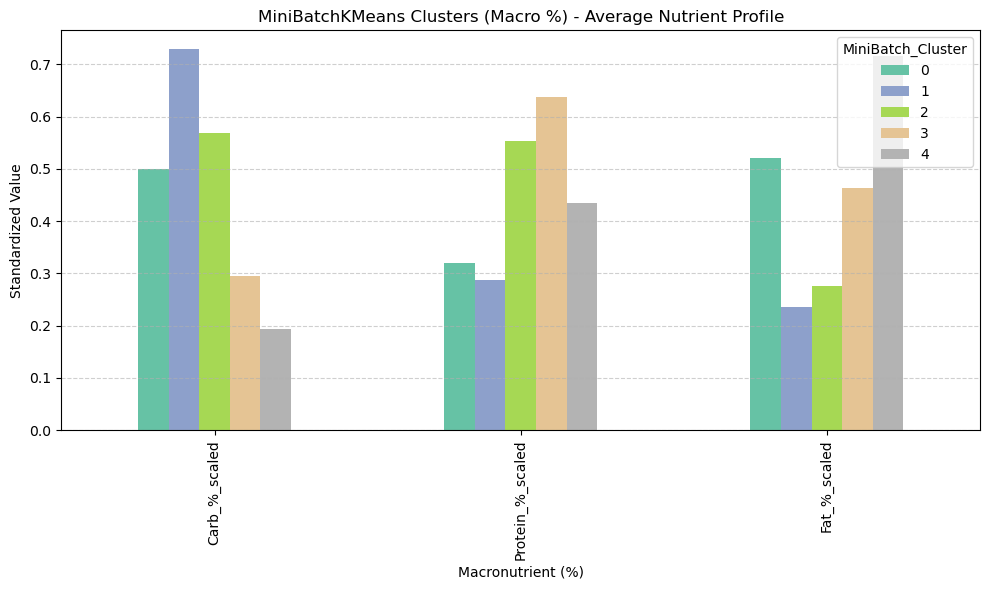

In [57]:
minmax_minibatch_df = minmax_df.copy()
minmax_minibatch_X = minmax_df[macro_percent_cols].copy()

# Train MiniBatchKMeans model
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42, batch_size=1000, n_init='auto')
minibatch_kmeans.fit(minmax_minibatch_X)

# Assign clusters
minmax_minibatch_df['MiniBatch_Cluster'] = minibatch_kmeans.predict(minmax_minibatch_X)

# Compute cluster means
cluster_means_minibatch = minmax_minibatch_df.groupby('MiniBatch_Cluster')[macro_percent_cols].mean()

# Plot
plt.figure(figsize=(10, 6))
cluster_means_minibatch.T.plot(kind='bar', figsize=(10, 6), colormap='Set2')
plt.title("MiniBatchKMeans Clusters (Macro %) - Average Nutrient Profile")
plt.ylabel("Standardized Value")
plt.xlabel("Macronutrient (%)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [87]:
k_range = range(3, 8)
minmax_minibatch_results = []

print("🔍 Running MiniBatchKMeans (MinMaxScaler) hyperparameter tuning...")

for k in k_range:
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=2048, n_init='auto')
    labels = minibatch_kmeans.fit_predict(minmax_minibatch_X)
    dbi = davies_bouldin_score(minmax_minibatch_X, labels)
    ch_score = calinski_harabasz_score(minmax_minibatch_X, labels)
    inertia = minibatch_kmeans.inertia_


    minmax_minibatch_results.append({
        'k': k,
        'davies_bouldin_index': dbi,
        'calinski_harabasz': ch_score,
        'inertia': inertia
    })

    print(f"k={k} ➤ DBI={dbi:.4f}, CH={ch_score:.2f}, Inertia={inertia:.2f}")

minmax_minibatch_results_df = pd.DataFrame(minmax_minibatch_results)

🔍 Running MiniBatchKMeans (MinMaxScaler) hyperparameter tuning...
k=3 ➤ DBI=1.1256, CH=189737.79, Inertia=14332.49
k=4 ➤ DBI=0.8585, CH=210191.74, Inertia=10506.52
k=5 ➤ DBI=0.9642, CH=201827.97, Inertia=8829.43
k=6 ➤ DBI=0.9421, CH=214375.91, Inertia=7117.01
k=7 ➤ DBI=0.8953, CH=215921.86, Inertia=6111.61


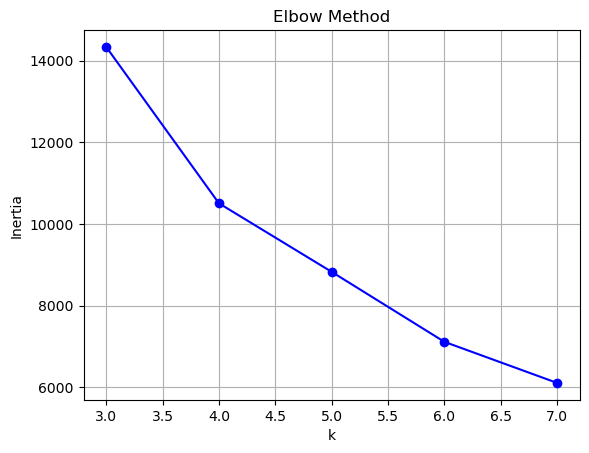

In [110]:
plt.plot([r['k'] for r in minmax_minibatch_results], [r['inertia'] for r in minmax_minibatch_results], 'o-', color='blue')
plt.title('Elbow Method')
plt.xlabel('k'), plt.ylabel('Inertia')
plt.grid(True)
plt.show()

<div style="text-align: center;">
  <h1>SOM + K-means (MINMAX)</h1>
</div>

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

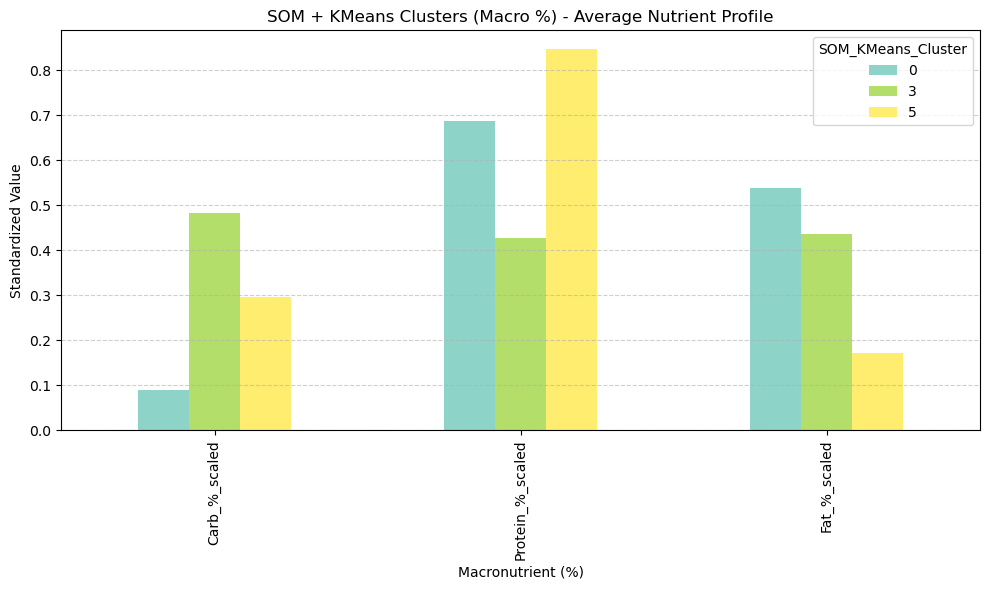

In [ ]:
from minisom import MiniSom
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Make a copy of your DataFrame
som_kmeans_df = minmax_df.copy()
som_kmeans_X = minmax_df[macro_percent_cols].copy().values

# SOM settings
som_x, som_y =  15,15  # 10x10 grid
k = 7  # Match your KMeans cluster count

# Train SOM
som = MiniSom(x=som_x, y=som_y, input_len=som_X.shape[1], sigma=1.0, learning_rate=0.05, random_seed=42)
som.train_random(som_X, num_iteration=2000)

# Flatten SOM weights
som_weights = som.get_weights().reshape(-1, som_X.shape[1])

# KMeans on SOM neuron weights
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
kmeans.fit(som_weights)

# Assign cluster to each data point via SOM BMU
bmu_indices = [som.winner(xi) for xi in som_X]
flat_bmu_indices = [i * som_y + j for i, j in bmu_indices]
som_cluster_labels = [kmeans.labels_[idx] for idx in flat_bmu_indices]

# Add labels to DataFrame
som_df['SOM_KMeans_Cluster'] = som_cluster_labels

# Compute cluster means
cluster_means_som_kmeans = som_df.groupby('SOM_KMeans_Cluster')[macro_percent_cols].mean()

# Plot
plt.figure(figsize=(10, 6))
cluster_means_som_kmeans.T.plot(kind='bar', figsize=(10, 6), colormap='Set3')
plt.title("SOM + KMeans Clusters (Macro %) - Average Nutrient Profile")
plt.ylabel("Standardized Value")
plt.xlabel("Macronutrient (%)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



In [95]:
from minisom import MiniSom
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd



# SOM config
som_x, som_y = 15, 15  # Grid size

som_kmeans_results = []

print("🔍 Running SOM + KMeans hyperparameter tuning...")

for k in range(3, 8):
    # 1. Train SOM
    som = MiniSom(x=som_x, y=som_y, input_len=som_X.shape[1], sigma=1.0, learning_rate=0.05, random_seed=42)
    som.train_random(som_X, num_iteration=2000)

    # 2. Flatten weights and cluster with KMeans
    som_weights = som.get_weights().reshape(-1, som_X.shape[1])
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(som_weights)

    # 3. Assign SOM BMUs and map them to KMeans labels
    bmu_indices = [som.winner(xi) for xi in som_X]
    flat_bmu_indices = [i * som_y + j for i, j in bmu_indices]
    cluster_labels = [kmeans.labels_[idx] for idx in flat_bmu_indices]

    # 4. Metrics
    inertia = kmeans.inertia_
    dbi = davies_bouldin_score(som_X, cluster_labels)
    ch_score = calinski_harabasz_score(som_X, cluster_labels)

    som_kmeans_results.append({
        'k': k,
        'davies_bouldin_index': dbi,
        'calinski_harabasz': ch_score,
        'inertia': inertia
    })

    print(f"k={k} ➤ DBI={dbi:.4f}, CH={ch_score:.2f}, Inertia={inertia:.2f}")

# Results DataFrame
som_kmeans_results_df = pd.DataFrame(som_kmeans_results)


🔍 Running SOM + KMeans hyperparameter tuning...


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=3 ➤ DBI=1.1003, CH=193178.58, Inertia=89.03


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=4 ➤ DBI=0.7265, CH=17421.89, Inertia=66.81


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=5 ➤ DBI=0.7265, CH=17421.89, Inertia=54.71


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=6 ➤ DBI=0.7916, CH=27466.77, Inertia=49.11


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


k=7 ➤ DBI=0.8033, CH=34758.67, Inertia=41.72
